In [2]:
import os
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from tqdm.contrib.concurrent import process_map

sns.set_theme()

In [3]:
def visualize_segment(file):
    segment = pd.read_csv(file) 
    plots = [
        {'names': ['latActive', 'steeringPressed'], 'row': 0, 'col': 0, 'title': 'Active states {0, 1}'},
        {'names': ['vEgo'], 'row': 0, 'col': 1, 'title': 'vEgo (m/s)'},
        {'names': ['steer', 'steerFiltered'], 'row': 1, 'col': 0, 'title': 'steer command [-1,1]'},
        {'names': ['latAccelDesired', 'latAccelSteeringAngle', 'latAccelLocalizer'], 'row': 1, 'col': 1, 'title': 'Lateral Acceleration (m/s^2)'},
        {'names': ['roll'], 'row': 2, 'col': 0, 'title': 'Road roll (rad)'},
        {'names': ['aEgo'], 'row': 2, 'col': 1, 'title': 'aEgo (m/s^2)'},
    ]
    kwargs = {
        'alpha': 0.8,
    }
    fig, axs = plt.subplots(3, 2, figsize=(20, 10))
    for plot in plots:
        for name in plot['names']:
            axs[plot['row'], plot['col']].plot(segment['t'], segment[name], label=name, **kwargs)
        axs[plot['row'], plot['col']].set_title(plot.get('title'))
        axs[plot['row'], plot['col']].legend()
        
    plt.suptitle(f"Platform: {PLATFORM}; File: {file.name}")
    plt.tight_layout()
    plt.show()

def get_samples(files):
    dfs = process_map(pd.read_csv, files, max_workers=24, chunksize=100)
    df = pd.concat(dfs, ignore_index=True)
    return df
    

In [4]:
BASE_PATH = pathlib.Path("/mnt/ML_Codes/controls_challenge/data")
PLATFORM = BASE_PATH.name
files = list(BASE_PATH.glob("*.csv"))


KeyError: 'latActive'

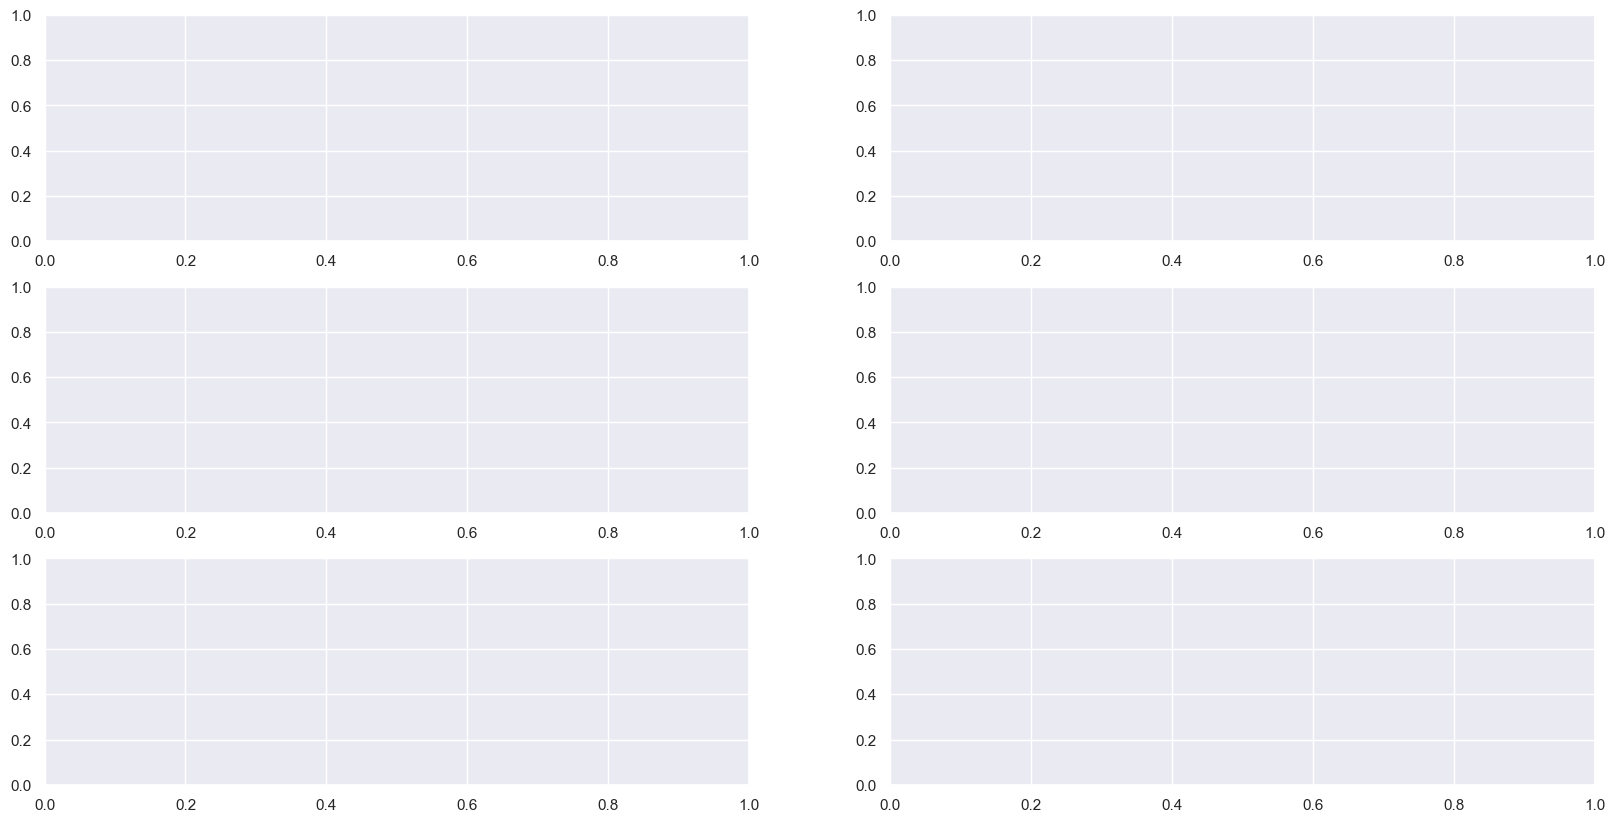

In [5]:
visualize_segment(files[5])

  0%|          | 0/21000 [00:00<?, ?it/s]

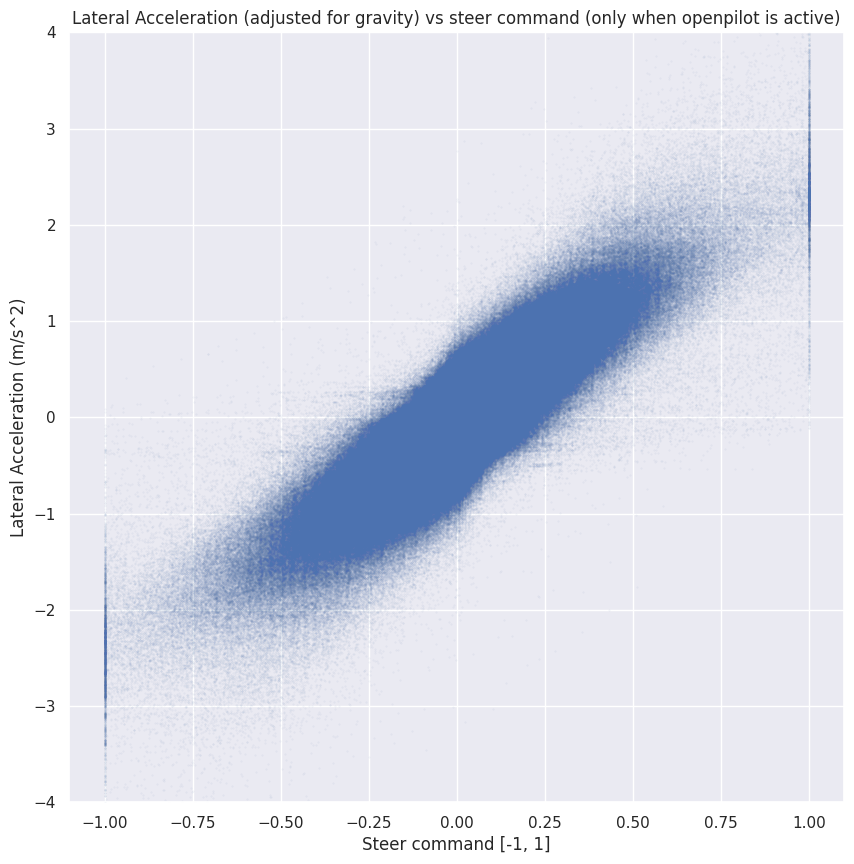

In [5]:
ACC_G = 9.81

df = get_samples(files)
# conside only samples where openpilot is driving (latActive and not steeringPressed)
df = df[(df['latActive'])&(~df['steeringPressed'])]

plt.figure(figsize=(10,10))

# The convention we use is -ve steer
plt.scatter(-df['steerFiltered'], df['latAccelSteeringAngle'] - np.sin(ACC_G * df['roll']), s=0.1, alpha=0.1)
plt.xlabel("Steer command [-1, 1]")
plt.ylabel("Lateral Acceleration (m/s^2)")
plt.ylim(-4, 4)
plt.title("Lateral Acceleration (adjusted for gravity) vs steer command (only when openpilot is active)")
plt.show()